In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
months = ['January', 'February', 'March', 'April', 'October', 'November', 'December']

In [3]:
acc = list()

In [4]:
f1 = list()

In [5]:
err = list()

In [6]:
house_data = pd.read_csv("../preprocessed_data/std_test_data_6150c70f76a3f4b0c6e303de7da9422aceb37345.csv")

In [7]:
house_data.head()

,index,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,HourofDay,Day,T_ctrl,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,T_out,RH_out
0,0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,1.177675,1.14455,-0.270977,0,0,1.177675,0.322013,1.760593
1,1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,1.177675,1.14455,-0.270977,0,17,1.177675,0.322013,1.760593
2,2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,1.177675,1.14455,-0.270977,6,19,1.177675,0.322013,1.760593
3,3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.398793,1.14455,-0.270977,20,20,0.398793,0.322013,1.760593
4,4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,0.398793,1.14455,-0.270977,20,20,0.398793,0.322013,1.760593


In [8]:
house_data.Month.value_counts()

12    8918
11    8621
1     8612
3     8255
4     8244
10    7311
2     5221
5     4975
6     1305
Name: Month, dtype: int64

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
cumulative_df = pd.DataFrame({"T_ctrl": [], 
                              "T_stp_heat": [], 
                              "T_out" : [], 
                              "RH_out" : [],
                              "auxHeat1" : []})

# January

In [11]:
working_df = house_data[house_data.Month == 1]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6884, 34) (6884, 21) (1722, 34) (1722, 21)


In [12]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
689/689 [==============================] - 3s 4ms/step - loss: 1.0633 - accuracy: 0.7956 - val_loss: 0.8172 - val_accuracy: 0.8409
Epoch 2/20
689/689 [==============================] - 2s 3ms/step - loss: 0.7698 - accuracy: 0.8470 - val_loss: 0.8260 - val_accuracy: 0.8200
Epoch 3/20
689/689 [==============================] - 2s 3ms/step - loss: 0.7537 - accuracy: 0.8528 - val_loss: 0.7657 - val_accuracy: 0.8484
Epoch 4/20
689/689 [==============================] - 2s 3ms/step - loss: 0.7426 - accuracy: 0.8540 - val_loss: 0.7629 - val_accuracy: 0.8479
Epoch 5/20
689/689 [==============================] - 2s 3ms/step - loss: 0.7338 - accuracy: 0.8552 - val_loss: 0.7672 - val_accuracy: 0.8513
Epoch 6/20
689/689 [==============================] - 2s 3ms/step - loss: 0.7264 - accuracy: 0.8572 - val_loss: 0.7667 - val_accuracy: 0.8449
Epoch 7/20
689/689 [==============================] - 2s 3ms/step - loss: 0.7237 - accuracy: 0.8562 - val_loss: 0.7498 - val_accuracy: 0.8519
Epoch 

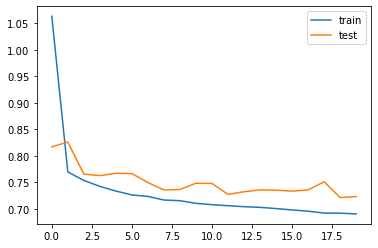

In [13]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

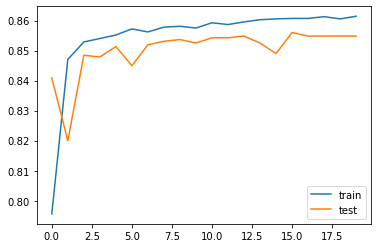

In [14]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [15]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

159675
144900
Error Percentage in predicted values is : 9.253170502583373 %


In [16]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# February

In [17]:
working_df = house_data[house_data.Month == 2]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(11061, 34) (11061, 21) (2766, 34) (2766, 21)


In [18]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
1107/1107 [==============================] - 4s 4ms/step - loss: 0.9952 - accuracy: 0.8082 - val_loss: 0.7858 - val_accuracy: 0.8474
Epoch 2/20
1107/1107 [==============================] - 4s 4ms/step - loss: 0.8145 - accuracy: 0.8437 - val_loss: 0.7615 - val_accuracy: 0.8547
Epoch 3/20
1107/1107 [==============================] - 4s 4ms/step - loss: 0.7965 - accuracy: 0.8470 - val_loss: 0.7497 - val_accuracy: 0.8557
Epoch 4/20
1107/1107 [==============================] - 4s 3ms/step - loss: 0.7873 - accuracy: 0.8481 - val_loss: 0.7473 - val_accuracy: 0.8572
Epoch 5/20
1107/1107 [==============================] - 4s 3ms/step - loss: 0.7775 - accuracy: 0.8490 - val_loss: 0.7683 - val_accuracy: 0.8543
Epoch 6/20
1107/1107 [==============================] - 3s 3ms/step - loss: 0.7684 - accuracy: 0.8504 - val_loss: 0.7397 - val_accuracy: 0.8576
Epoch 7/20
1107/1107 [==============================] - 4s 4ms/step - loss: 0.7602 - accuracy: 0.8506 - val_loss: 0.7435 - val_accuracy:

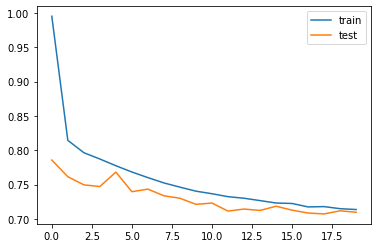

In [19]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

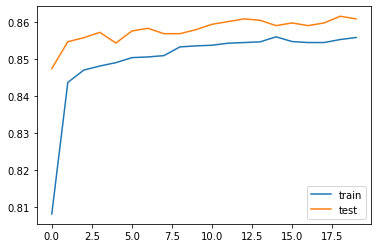

In [20]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [21]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

235110
228300
Error Percentage in predicted values is : 2.896516524180171 %


In [22]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# March

In [23]:
working_df = house_data[house_data.Month == 3]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17665, 34) (17665, 21) (4417, 34) (4417, 21)


In [24]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
1767/1767 [==============================] - 7s 4ms/step - loss: 0.8411 - accuracy: 0.8474 - val_loss: 0.7263 - val_accuracy: 0.8644
Epoch 2/20
1767/1767 [==============================] - 6s 3ms/step - loss: 0.6548 - accuracy: 0.8791 - val_loss: 0.6880 - val_accuracy: 0.8689
Epoch 3/20
1767/1767 [==============================] - 6s 3ms/step - loss: 0.6367 - accuracy: 0.8812 - val_loss: 0.7056 - val_accuracy: 0.8646
Epoch 4/20
1767/1767 [==============================] - 6s 3ms/step - loss: 0.6272 - accuracy: 0.8834 - val_loss: 0.6915 - val_accuracy: 0.8669
Epoch 5/20
1767/1767 [==============================] - 7s 4ms/step - loss: 0.6204 - accuracy: 0.8842 - val_loss: 0.6659 - val_accuracy: 0.8714
Epoch 6/20
1767/1767 [==============================] - 6s 3ms/step - loss: 0.6165 - accuracy: 0.8841 - val_loss: 0.6583 - val_accuracy: 0.8723
Epoch 7/20
1767/1767 [==============================] - 6s 4ms/step - loss: 0.6106 - accuracy: 0.8841 - val_loss: 0.6806 - val_accuracy:

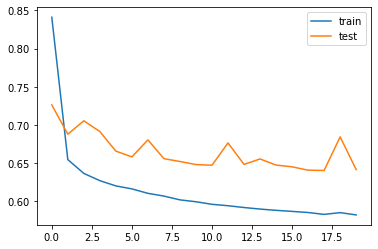

In [25]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

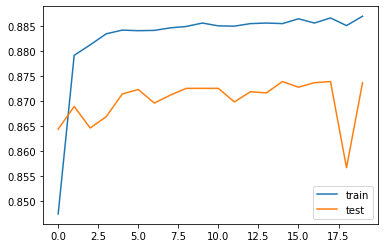

In [26]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [27]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

337980
318300
Error Percentage in predicted values is : 5.822829753239836 %


In [28]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# April

In [29]:
working_df = house_data[house_data.Month == 4]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(24260, 34) (24260, 21) (6066, 34) (6066, 21)


In [30]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
2426/2426 [==============================] - 7s 3ms/step - loss: 0.6658 - accuracy: 0.8864 - val_loss: 0.5295 - val_accuracy: 0.9021
Epoch 2/20
2426/2426 [==============================] - 7s 3ms/step - loss: 0.5397 - accuracy: 0.9014 - val_loss: 0.5065 - val_accuracy: 0.9092
Epoch 3/20
2426/2426 [==============================] - 7s 3ms/step - loss: 0.5242 - accuracy: 0.9030 - val_loss: 0.4888 - val_accuracy: 0.9097
Epoch 4/20
2426/2426 [==============================] - 7s 3ms/step - loss: 0.5184 - accuracy: 0.9035 - val_loss: 0.4883 - val_accuracy: 0.9093
Epoch 5/20
2426/2426 [==============================] - 7s 3ms/step - loss: 0.5120 - accuracy: 0.9047 - val_loss: 0.4874 - val_accuracy: 0.9095
Epoch 6/20
2426/2426 [==============================] - 7s 3ms/step - loss: 0.5073 - accuracy: 0.9047 - val_loss: 0.4866 - val_accuracy: 0.9090
Epoch 7/20
2426/2426 [==============================] - 7s 3ms/step - loss: 0.5048 - accuracy: 0.9048 - val_loss: 0.4844 - val_accuracy:

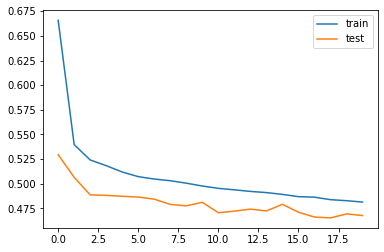

In [31]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

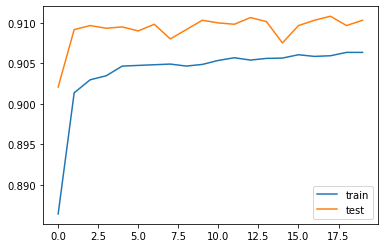

In [32]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [33]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

368490
376200
Error Percentage in predicted values is : 2.092322722461939 %


In [34]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# October

In [35]:
working_df = house_data[house_data.Month == 10]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30109, 34) (30109, 21) (7528, 34) (7528, 21)


In [36]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
3011/3011 [==============================] - 10s 3ms/step - loss: 0.5642 - accuracy: 0.9036 - val_loss: 0.4900 - val_accuracy: 0.9106
Epoch 2/20
3011/3011 [==============================] - 9s 3ms/step - loss: 0.4550 - accuracy: 0.9170 - val_loss: 0.4685 - val_accuracy: 0.9145
Epoch 3/20
3011/3011 [==============================] - 9s 3ms/step - loss: 0.4439 - accuracy: 0.9191 - val_loss: 0.4617 - val_accuracy: 0.9134
Epoch 4/20
3011/3011 [==============================] - 10s 3ms/step - loss: 0.4377 - accuracy: 0.9199 - val_loss: 0.4552 - val_accuracy: 0.9168
Epoch 5/20
3011/3011 [==============================] - 11s 4ms/step - loss: 0.4336 - accuracy: 0.9203 - val_loss: 0.4579 - val_accuracy: 0.9162
Epoch 6/20
3011/3011 [==============================] - 10s 3ms/step - loss: 0.4317 - accuracy: 0.9200 - val_loss: 0.4502 - val_accuracy: 0.9170
Epoch 7/20
3011/3011 [==============================] - 11s 4ms/step - loss: 0.4284 - accuracy: 0.9200 - val_loss: 0.4451 - val_accu

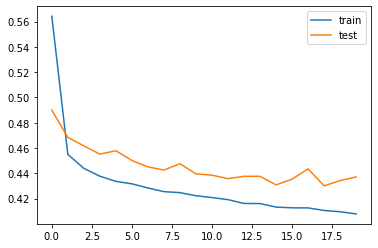

In [37]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

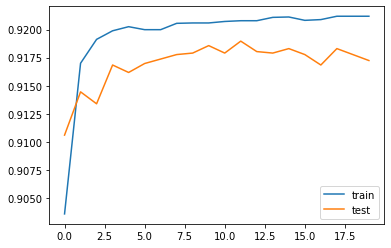

In [38]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [39]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

400635
387000
Error Percentage in predicted values is : 3.4033471863416827 %


In [40]:
f1_score(y_test, y_predicted, average = 'weighted')

0.885134718796944

In [41]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [42]:
acc.append(max(history.history['accuracy']))

# November

In [43]:
working_df = house_data[house_data.Month == 11]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37006, 34) (37006, 21) (9252, 34) (9252, 21)


In [44]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
3701/3701 [==============================] - 12s 3ms/step - loss: 0.5485 - accuracy: 0.9064 - val_loss: 0.4666 - val_accuracy: 0.9126
Epoch 2/20
3701/3701 [==============================] - 12s 3ms/step - loss: 0.4464 - accuracy: 0.9205 - val_loss: 0.4461 - val_accuracy: 0.9182
Epoch 3/20
3701/3701 [==============================] - 12s 3ms/step - loss: 0.4358 - accuracy: 0.9218 - val_loss: 0.4479 - val_accuracy: 0.9187
Epoch 4/20
3701/3701 [==============================] - 14s 4ms/step - loss: 0.4312 - accuracy: 0.9219 - val_loss: 0.4416 - val_accuracy: 0.9176
Epoch 5/20
3701/3701 [==============================] - 13s 4ms/step - loss: 0.4261 - accuracy: 0.9221 - val_loss: 0.4367 - val_accuracy: 0.9194
Epoch 6/20
3701/3701 [==============================] - 13s 4ms/step - loss: 0.4229 - accuracy: 0.9227 - val_loss: 0.4327 - val_accuracy: 0.9189
Epoch 7/20
3701/3701 [==============================] - 13s 4ms/step - loss: 0.4211 - accuracy: 0.9222 - val_loss: 0.4288 - val_ac

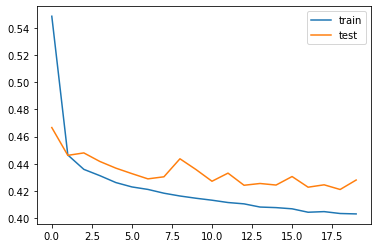

In [45]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

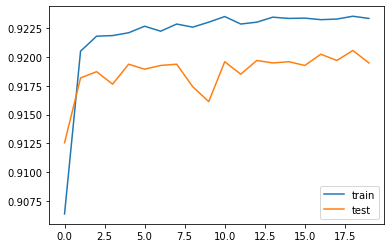

In [46]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [47]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

493335
502500
Error Percentage in predicted values is : 1.8577639940405608 %


In [48]:
f1_score(y_test, y_predicted, average = 'weighted')

0.8869567623835494

In [49]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [50]:
acc.append(max(history.history['accuracy']))

# December

In [51]:
working_df = house_data[house_data.Month == 12]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(44140, 34) (44140, 21) (11036, 34) (11036, 21)


In [52]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
4414/4414 [==============================] - 12s 3ms/step - loss: 0.5264 - accuracy: 0.9102 - val_loss: 0.4297 - val_accuracy: 0.9236
Epoch 2/20
4414/4414 [==============================] - 12s 3ms/step - loss: 0.4433 - accuracy: 0.9204 - val_loss: 0.4316 - val_accuracy: 0.9267
Epoch 3/20
4414/4414 [==============================] - 12s 3ms/step - loss: 0.4350 - accuracy: 0.9216 - val_loss: 0.4126 - val_accuracy: 0.9264
Epoch 4/20
4414/4414 [==============================] - 13s 3ms/step - loss: 0.4292 - accuracy: 0.9217 - val_loss: 0.4081 - val_accuracy: 0.9266
Epoch 5/20
4414/4414 [==============================] - 12s 3ms/step - loss: 0.4253 - accuracy: 0.9223 - val_loss: 0.4078 - val_accuracy: 0.9262
Epoch 6/20
4414/4414 [==============================] - 12s 3ms/step - loss: 0.4219 - accuracy: 0.9220 - val_loss: 0.4116 - val_accuracy: 0.9262
Epoch 7/20
4414/4414 [==============================] - 13s 3ms/step - loss: 0.4200 - accuracy: 0.9223 - val_loss: 0.4280 - val_ac

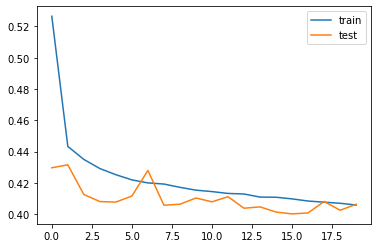

In [53]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

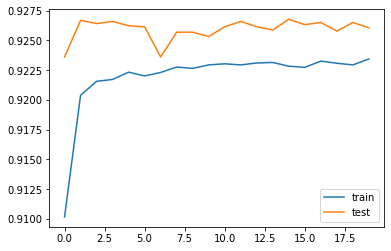

In [54]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [55]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

604530
609000
Error Percentage in predicted values is : 0.739417398640266 %


In [56]:
f1_score(y_test, y_predicted, average = 'weighted')

0.8956810836607729

In [57]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [58]:
acc.append(max(history.history['accuracy']))

[Text(0, 0.5, 'Weighted F1-Score'), Text(0.5, 0, 'Data Upto & Including')]

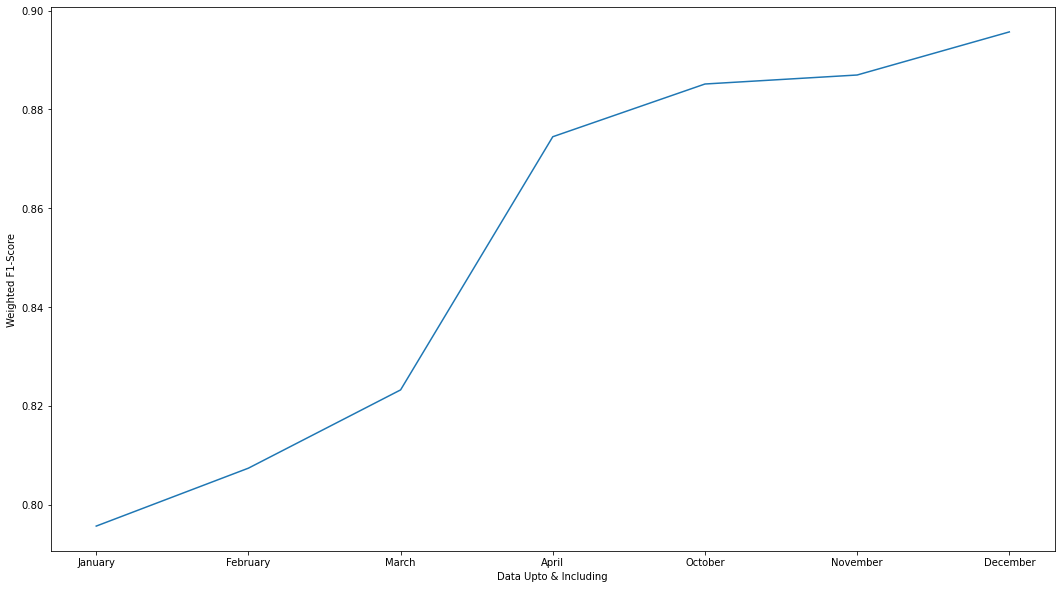

In [59]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = f1, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Weighted F1-Score")

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Data Upto & Including')]

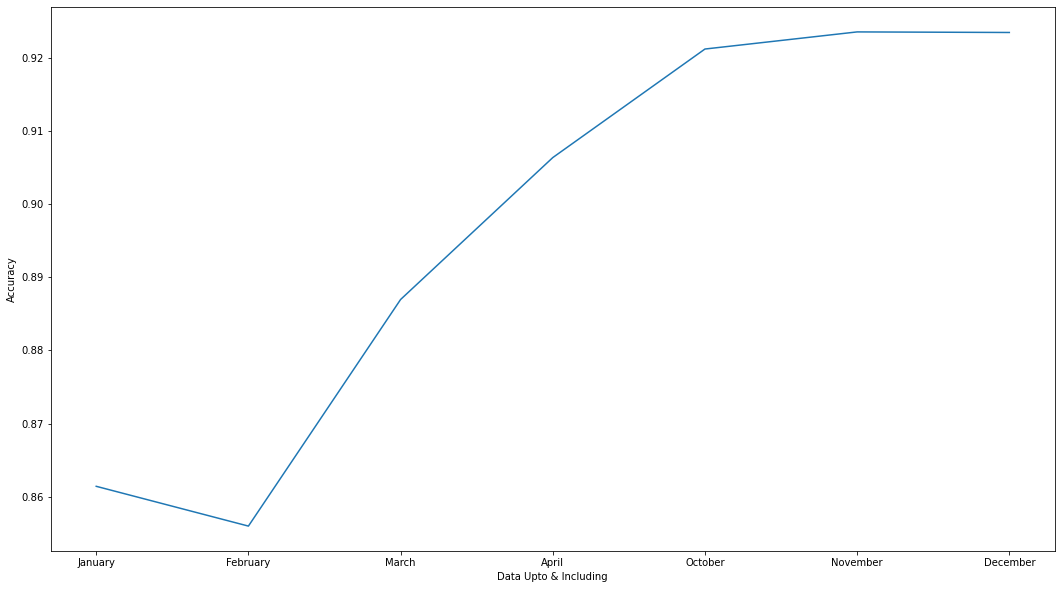

In [60]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = acc, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Accuracy")

[Text(0, 0.5, 'Error % in Prediction'), Text(0.5, 0, 'Data Upto & Including')]

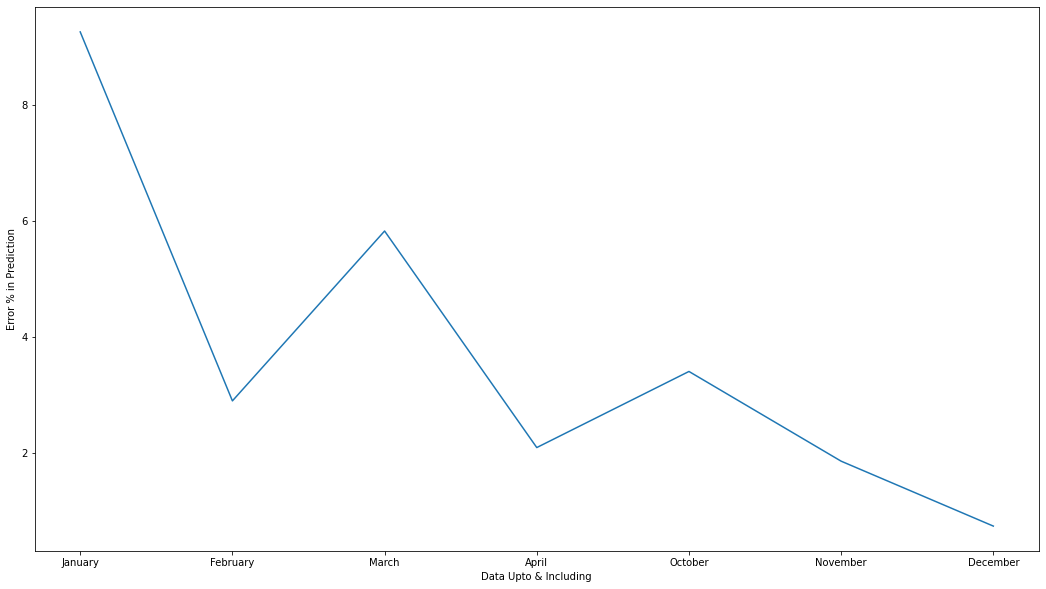

In [61]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = err, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Error % in Prediction")